In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing all the dependencies


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2

####Preprocessing

Load all the images and labels and preprocess them, convert to numpy arrays and append them to the respective lists and converting those to numpy arrays

In [12]:
path = '/content/drive/My Drive/Face-Mask-Detector/resources/dataset/'
imagePaths = list(paths.list_images(path))
images = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    images.append(image)
    labels.append(label)
images = np.array(images, dtype="float32")
labels = np.array(labels)

Getting the shapes of the arrays

In [13]:
print(images.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376,)


In [14]:
np.unique(labels)

array(['with_mask', 'without_mask'], dtype='<U12')

One-hot encode the labels as they are categorical

In [15]:
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

Perform the train test split by forming giving 20% dataset to test our model.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.20, stratify=labels)

Training image generator for data augmentation

In [17]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

###MobileNetV2 Models Building Block
<img src="https://drive.google.com/uc?id=1yKgIXSDFdadQNcD5sjmqmJ07a6lQPCzq" width="500" height = '500' layout="centre">

For this task, we will be fine-tuning the MobileNet V2 architecture, a highly efficient architecture which works well with limited computational capacity. 

Keras Functional API has been used to made the architecture of the model.

In [18]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))
X = baseModel.output
X = AveragePooling2D(pool_size=(7, 7))(X)
X = Flatten()(X)
X = Dense(128, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(2, activation="softmax")(X)
model = Model(inputs=baseModel.input, outputs=X)

9412608/9406464 [==============================] - 1s 0us/step


As we are using Transfer Learning i.e Pretrained MobileNetV2 we need to freeze its layers and train only last two dense layers.

In [19]:
for layer in baseModel.layers:
    layer.trainable = False

Final Architecture of our model.

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

Defining few parameters

In [22]:
batch_size = 128
epochs = 15

Defining the optimzer and compiling the model.

In [23]:
optimizer = Adam(lr=1e-4, decay=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Training the model.

In [24]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
            steps_per_epoch=len(X_train) // batch_size,
                 validation_data=(X_test, y_test),
                 validation_steps=len(X_test) // batch_size,
                 epochs=epochs)

Epoch 1/15
8/8 [==============================] - 44s 6s/step - loss: 0.8843 - accuracy: 0.5453 - val_loss: 0.5332 - val_accuracy: 0.7355
Epoch 2/15
8/8 [==============================] - 43s 5s/step - loss: 0.5146 - accuracy: 0.7366 - val_loss: 0.3228 - val_accuracy: 0.9312
Epoch 3/15
8/8 [==============================] - 45s 6s/step - loss: 0.3212 - accuracy: 0.8789 - val_loss: 0.2000 - val_accuracy: 0.9783
Epoch 4/15
8/8 [==============================] - 43s 5s/step - loss: 0.2287 - accuracy: 0.9259 - val_loss: 0.1419 - val_accuracy: 0.9783
Epoch 5/15
8/8 [==============================] - 43s 5s/step - loss: 0.1601 - accuracy: 0.9547 - val_loss: 0.1027 - val_accuracy: 0.9819
Epoch 6/15
8/8 [==============================] - 43s 5s/step - loss: 0.1258 - accuracy: 0.9660 - val_loss: 0.0804 - val_accuracy: 0.9855
Epoch 7/15
8/8 [==============================] - 43s 5s/step - loss: 0.1136 - accuracy: 0.9702 - val_loss: 0.0675 - val_accuracy: 0.9855
Epoch 8/15
8/8 [==================

We need to find the index of the label with corresponding largest predicted probability for each image in text set.

In [25]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.98      0.99       138
without_mask       0.98      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



Saving the model.h5 file so that it can loaded later to use for mask detection.

In [26]:
model.save("model", save_format="h5")

Plot the train and validation loss for our model using matplotlib library.

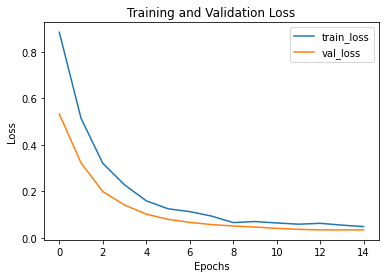

In [27]:
plt.plot(np.arange(0, epochs), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), hist.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

We have use used pretrained model to detect faces in images and used opencv deep neural network module to read model and its config file.

Weights of trained mask classifier model is loaded.

In [28]:
prototxtPath = '/content/drive/My Drive/Face-Mask-Detector/resources/face_detector/deploy.prototxt'
weightsPath = '/content/drive/My Drive/Face-Mask-Detector/resources/face_detector/res10_300x300_ssd_iter_140000.caffemodel'
face_model = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("model")

Preprocess the images using Blob module of opencv which resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels and them pass the blob throught our network to obtain the face which are detected by the model.

In [60]:
im_path='people2.jpg'
image = cv2.imdecode(np.fromfile(im_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
# image = cv2.imread('/content/drive/My Drive/maskclassifier/test/people2.jpg')
height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_model.setInput(blob)
detections = face_model.forward()       #detecting the faces

In this part we have loop through all the detections and if their score is greater than certain threshold then we have find the dimensions of face and use preprocessing steps used for training images. Then we have used model trained to predict the class of the face image by passing the image through it.

Then Opencv functions are used to create bounding boxes, put text and show the image.

Number of person with mask : 3
Number of person without mask : 197


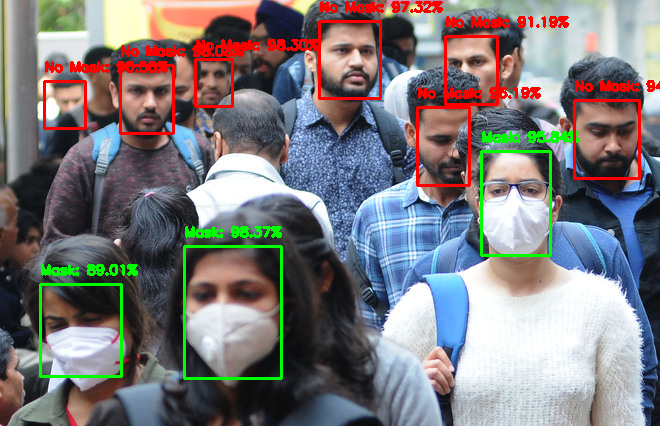

In [61]:
from google.colab.patches import cv2_imshow
threshold = 0.2
person_with_mask = 0;
person_without_mask = 0;
for i in range(0, detections.shape[2]):
    score = detections[0, 0, i, 2]
    if score > threshold:
        #coordinates of the bounding box
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        X_start, Y_start, X_end, Y_end = box.astype("int")
        X_start, Y_start = (max(0, X_start), max(0, Y_start))
        X_end, Y_end = (min(width - 1, X_end), min(height - 1, Y_end))

        face = image[Y_start:Y_end, X_start:X_end]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) #Convert to rgb
        face = cv2.resize(face, (224, 224)) #resize
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
    mask, withoutMask = model.predict(face)[0]
		
    if mask > withoutMask:
      label = "Mask"
      person_with_mask += 1
    else: 
      label = "No Mask"
      person_without_mask += 1
			
    if label == "Mask":
      color = (0, 255, 0)
    else:
      color = (0, 0, 255)
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    cv2.putText(image, label, (X_start, Y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (X_start, Y_start), (X_end, Y_end), color, 2)

print("Number of person with mask : {}".format(person_with_mask))
print("Number of person without mask : {}".format(person_without_mask))
cv2_imshow(image)